In [110]:
from collections.abc import Sequence
import json
from pathlib import Path
import re
from typing import Any

import h5py
import matplotlib.pyplot as plt
import nrrd
import numpy as np
from scipy.spatial.distance import euclidean
import vedo

from histalign.backend.maths import (
    compute_centre,
    compute_normal,
    compute_normal_from_raw,
    compute_origin,
)
from histalign.backend.models import AlignmentSettings, Orientation
from histalign.backend.registration import Registrator
from histalign.backend.registration.alignment import (
    build_aligned_array,
    build_aligned_array_new,
)
from histalign.backend.workspace import VolumeSlicer

vedo.settings.default_backend = "vtk"

In [111]:
PathType = str | Path

ALIGNMENT_FILE_NAME_PATTERN = re.compile(r"[0-9a-f]{32}\.json")
_SUPPORTED_TYPES = [".h5", ".hdf5", ".nrrd", ".json"]


def imshow(image: np.ndarray) -> None:
    plt.imshow(image)
    plt.axis(False)
    plt.show()


def show(objects: object | Sequence[object], axes: int = 3) -> None:
    try:
        objects = [] + objects
    except TypeError:
        objects = [objects]

    vedo.show(
        objects,
        axes=3,
        interactive=False,
    ).interactive().close()


def load_file(path: PathType) -> Any:
    path = Path(path)
    if (suffix := path.suffix) not in _SUPPORTED_TYPES:
        raise ValueError(
            f"File extension not supported. Received: {suffix}. Allowed: {' '.join(_SUPPORTED_TYPES)}"
        )

    if suffix == ".json":
        data = json.load(path.open())
    elif suffix == ".nrrd":
        data = nrrd.read(path)[0]
    elif suffix in [".h5", ".hdf5"]:
        with h5py.File(path) as handle:
            data = handle[list(handle.keys())[0]][:]

    return data

In [112]:
atlas_path = "/home/ediun/.local/share/histalign/atlases/average_template_100.nrrd"
atlas_array = load_file(atlas_path)
atlas_volume = vedo.Volume(atlas_array)

In [113]:
alignment_array = np.zeros_like(atlas_array)
alignment_volume = vedo.Volume(alignment_array)

## Building an alignment volume

To build the array, the following steps are taken:
1. List all the alignment paths (settings file ending in .json)
2. For each alignment path, load the settings.
3. For each settings, load the image.
4. For each image, generate a 3D set of points given the alignment settings.
5. For each set of points, insert the image data.
6. For each set of points, interpolate the data into the final volume (go from mesh to grid).

### 1. List all the alignment paths

In [114]:
# dimension = "2d"
dimension = "3d"

# hash_ = "1a862cb4e4"  # Single Normal
# hash_ = "526dc53bcb"  # Single Rotated
# hash_ = "8be574bb3c"  # Stack Normal
hash_ = "bb6ec0f5c8"  # Stack Rotated
alignment_directory = Path(
    f"/home/ediun/histalign-projects/microns_100_coronal_{dimension}_artificial/{hash_}"
)
alignment_paths = []
for child_path in alignment_directory.iterdir():
    if (
        child_path.is_dir()
        or re.fullmatch(ALIGNMENT_FILE_NAME_PATTERN, child_path.name) is None
    ):
        continue

    alignment_paths.append(child_path)

### 2. Load the settings

In [115]:
settings = AlignmentSettings(**load_file(alignment_paths[0]))

In [116]:
settings.histology_path = settings.histology_path.with_stem(
    settings.histology_path.stem.replace("_max", "")
)
# settings.volume_settings.pitch = 50
# settings.volume_settings.yaw = 50

### 3. Load the image

In [117]:
stack = load_file(settings.histology_path)

### 4A. Find the origin of the alignment

In [118]:
origin = compute_origin(
    compute_centre(settings.volume_settings.shape), settings.volume_settings
)

### 4B. Find the normal of the alignment

In [119]:
normal = compute_normal(settings.volume_settings)

### 4C. List multiples of normal for each image of the stack

In [120]:
# Assume the smallest dimension is the Z stack
z_dimension_index = stack.shape.index(min(stack.shape))
count = stack.shape[z_dimension_index]
multiples = range(-int(count / 2) + (count % 2 == 0), count // 2 + 1)

In [121]:
registrator = Registrator()
images = []
slicing = [
    slice(None),
] * len(stack.shape)
for index in range(count):
    slicing[z_dimension_index] = index
    image = stack[tuple(slicing)]

    registered_image = registrator.get_forwarded_image(image, settings, origin.tolist())

    images.append(image)

### 4D. Create plane for each origin

In [122]:
origins = []
for i in multiples:
    # TODO: Scale by project Z-distance
    origins.append(origin + i * normal)

individual_shape = list(stack[0].shape)
planes = []
for origin in origins:
    plane = vedo.Plane(pos=origin, normal=normal, s=individual_shape, c="blue")
    planes.append(plane)

### 4E. Generate 3D points for each pixel of the images

In [123]:
point_clouds = []
for plane in planes:
    # Extract 3 corners of the plane. p1 is the closest to (0, 0, 0)
    p0, p1, _, p3 = plane.points

    # Compute the shape of the plane from two perpendicular edges. This is a fence/post
    # problem where fences are  the Euclidean distances and  pixels (i.e., shape) are
    # the posts. Hence, need to add one to each.
    shape = list(map(round, (euclidean(p1, p0) + 1, euclidean(p1, p3) + 1)))
    # print(shape)

    # Compute the normals of those two edges and normalise them to be unit length
    normal1 = (p0 - p1) / euclidean(p1, p0)
    normal2 = (p3 - p1) / euclidean(p1, p3)

    # Generate a grid of coordinates from (0, 0, 0) the same size at the plane
    # and only technically 2D.
    # xs, ys = np.meshgrid(
    #     np.linspace(0, shape[0], shape[0]), np.linspace(0, shape[1], shape[1])
    # )
    xs, ys = np.meshgrid(
        np.linspace(0, round(euclidean(p1, p0)), round(euclidean(p1, p0))),
        np.linspace(0, round(euclidean(p1, p3)), round(euclidean(p1, p3))),
    )
    points = np.vstack([xs.ravel(), ys.ravel()])

    # Convert the grid to 3D based on the plane orthogonal normals
    points = np.dot(np.vstack((normal1, normal2)).T, points).T

    # Translate grid origin to the plane's bottom-right
    points = p1 + points

    points = vedo.Points(points)
    point_clouds.append(points)

In [124]:
# 1.5 * max(settings.volume_settings.shape)

In [125]:
# np.linspace(0, int(euclidean(p1, p0)), int(euclidean(p1, p0)))

In [126]:
# plane = vedo.Plane(pos=[0, 0, 0], normal=[1, 0, 0], s=(3, 3))
#
# # Extract 3 corners of the plane. p1 is the closest to (0, 0, 0)
# p0, p1, _, p3 = plane.points
#
# # Compute the shape of the plane from two perpendicular edges. This is a fence/post
# # problem where fences are  the Euclidean distances and  pixels (i.e., shape) are
# # the posts. Hence, need to add one to each.
# shape = list(map(round, (euclidean(p1, p0) + 1, euclidean(p1, p3) + 1)))
#
# # Compute the normals of those two edges and normalise them to be unit length
# normal1 = (p0 - p1) / euclidean(p1, p0)
# normal2 = (p3 - p1) / euclidean(p1, p3)
#
# # Generate a grid of coordinates from (0, 0, 0) the same size at the plane
# # and only technically 2D.
# # xs, ys = np.meshgrid(
# #     np.linspace(0, shape[0], shape[0]),
# #     np.linspace(0, shape[1], shape[1]),
# # )
# xs, ys = np.meshgrid(
#     np.linspace(0, int(euclidean(p1, p0)), int(euclidean(p1, p0))),
#     np.linspace(0, int(euclidean(p1, p3)), int(euclidean(p1, p3))),
# )
# points = np.vstack([xs.ravel(), ys.ravel()])
#
# # Convert the grid to 3D based on the plane orthogonal normals
# points = np.dot(np.vstack((normal1, normal2)).T, points).T
#
# # Translate grid origin to the plane's bottom-right
# points = p1 + points
#
# points = vedo.Points(points)

### 5. Insert image data into points clouds

In [127]:
# print(images[0].shape)
# print(point_clouds[0].points.shape)

In [137]:
for image, points, origin in zip(images, point_clouds, origins):
    points.pointdata["ImageScalars"] = image.flatten()

In [138]:
show(
    [
        *point_clouds,
        atlas_volume,
    ]
)

### 6. Interpolate the point clouds into the final volume

In [141]:
# 6. Interpolate the point clouds into the final volume
# Array where planes are inserted
interpolation_array = np.zeros(settings.volume_settings.shape, dtype=np.uint16)
# Placeholder volume used to query the grid coordinates when interpolating
tmp_volume = vedo.Volume(interpolation_array)
for points in point_clouds:
    # Interpolate and store the result in a temporary array
    tmp_array = tmp_volume.interpolate_data_from(points, radius=1).tonumpy()
    tmp_array = np.round(tmp_array).astype(np.uint16)

    # TODO: Might be worth thinking of another way to merge. Using the maximum works
    #       fine when working with non-overlapping slices but a mean or something
    #       similar might make more sense when tmp_array and aligned_array have
    #       common, non-zero points.
    # Merge the new plane into the master array
    interpolation_array[:] = np.maximum(interpolation_array, tmp_array)

alignment_volume = vedo.Volume(interpolation_array)

### 7. Checking the work

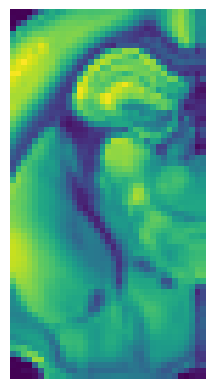

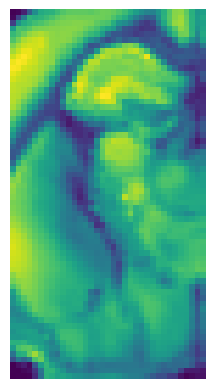

In [143]:
atlas_slicer = VolumeSlicer(volume=atlas_volume)
target_image = atlas_slicer.slice(settings.volume_settings)

alignment_slicer = VolumeSlicer(volume=alignment_volume)
actual_image = alignment_slicer.slice(settings.volume_settings)

# roi = (slice(None), slice(None))
# roi = (slice(66, 132), slice(66, 100))
roi = (slice(66, 132), slice(66, 101))
# roi = (slice(75, 85), slice(90, 100))
# roi = (slice(95, 105), slice(95, 105))

imshow(target_image[roi])
imshow(actual_image[roi])

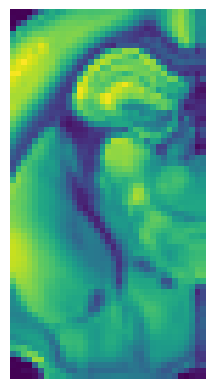

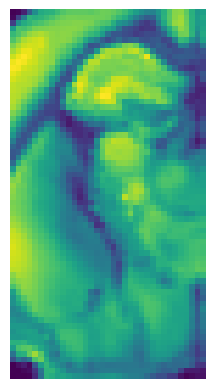

In [144]:
atlas_slicer = VolumeSlicer(volume=atlas_volume)
target_image = atlas_slicer.slice(settings.volume_settings)

alignment_slicer = VolumeSlicer(volume=alignment_volume)
actual_image = alignment_slicer.slice(settings.volume_settings)

imshow(target_image[roi])
imshow(actual_image[roi])

### 8. Comparing with current implementation

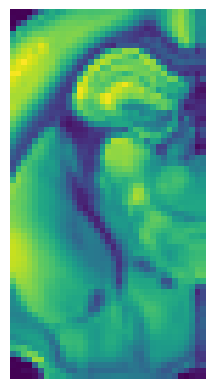

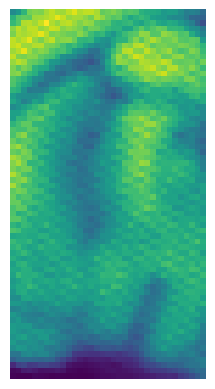

In [146]:
build_aligned_array(alignment_directory, "", "", "", force=True)
current_alignment_array = load_file(
    f"/home/ediun/histalign-projects/microns_100_coronal_{dimension}_artificial/{hash_}/volumes/aligned/{hash_}.h5"
)
current_alignment_volume = vedo.Volume(current_alignment_array)

atlas_slicer = VolumeSlicer(volume=atlas_volume)
target_image = atlas_slicer.slice(settings.volume_settings)

current_alignment_slicer = VolumeSlicer(volume=current_alignment_volume)
actual_image = current_alignment_slicer.slice(settings.volume_settings)

imshow(target_image[roi])
imshow(actual_image[roi])

### Conclusion

There is a sizable difference between the implementations. This needs to be fixed.